# Plotting the stream function

This notebook aims at providing the stream lines and stream functions for a 2D steady-state flow problem with uniform hydraulic conductivity.

## Solving the head problem

First, we solve the steady-state flow problem:

\begin{equation}
\mathrm{div}\left( K \overrightarrow{\nabla} h \right) = 0
\end{equation}

where h is the hydraulic head and K the hydraulic conductivity. To solve this, the 2D module has everything we need.

In [139]:
# i import everythying we need (see 2D sparse transient assignment)
import matplotlib.cm as cmap
import matplotlib.pyplot as plt
import numpy as np
from module_2D import Boundary_Def
from module_2D import build_2D_matrix
from module_2D import mat2vec
from module_2D import Problem_Def
from module_2D import vec2mat
from module_2D import index_to_row_col
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import spsolve
import math

In [140]:
# i create boundary conditions: flux from the top and the left, no flux on the bottom, 
# and a constant head value on the right.  You can change that!
west = Boundary_Def("flux", val=0.1)
east = Boundary_Def("const", val=0)

north = Boundary_Def("flux", val=0.1) # not important since the phreatic line will govern most of it
south = Boundary_Def("flux", val=0)
bc_dict = {"west": west, "north": north, "east": east, "south": south}
# The latter array bc_dict will be sent to the different functions

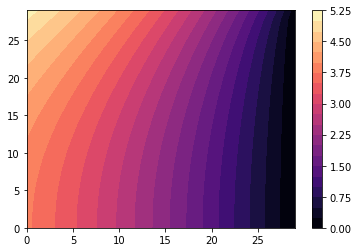

In [141]:
# In this cell, i just solve a the problem with the boundary conditions on top. It's simply steady-state.

import pdb
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
N = 30
sat_matrix = np.zeros((N,N))
head = np.zeros((N,N))
width_x = 30  # m
width_y = 30  # m


n_x = 30
n_y = n_x
dx = 1 
dy = 1
K = 0.001
the_prob = Problem_Def(n_x, n_y, K, width_x, width_y)
prob = Problem_Def(n_x, n_y, K, width_x, width_y)
Qsource = np.zeros((n_y, n_x))
D_matrix = K*np.ones((n_y,n_x))

A, b = build_2D_matrix(bc_dict,prob, D_matrix, Qsource)

A = csr_matrix(A, copy=True)
head_array = spsolve(A, b)

# I convert the vector to the 2D matrix
n = n_x * n_y
head_2D = vec2mat(head_array, n_y, n_x)

# i define the real coordinates 
y1, x1 = np.mgrid[slice(0, width_y, 1),
                slice(0, width_x, 1)]

# i plot it
cm = cmap.get_cmap("magma")
plt.contourf(x1, y1, head_2D, 20, cmap=cm)
plt.colorbar()

## Velocity field

Now, we can compute the velocity fields:

\begin{equation}
\begin{array}{lll}
v_x & = & - K \frac{\partial h}{\partial x} \\
v_y & = & - K \frac{\partial h}{\partial y}
\end{array}
\end{equation}

So that means we have to compute the derivatives of the head function at every point.

We are going to apply the centered difference everywhere within the domain, and a foward/backward for the edges of the domain.


In [143]:

vx = np.zeros((n_y,n_x))
vy = np.zeros((n_y,n_x))

# Here the velocities are computed as if K is constant everywhere, you have to adapt it if K is not 
# (using harmonic averaging between the cells)

for ind in range(n):    
    i, j = index_to_row_col(ind, n_y, n_x)
    if i == 0:  # SOUTH BOUNDARY:   foward difference for vy
        vy[i,j] = -(head_2D[i+1,j]-head_2D[i,j])/dy*K
        if j == 0:
            vx[i,j] = -(head_2D[i,j+1]-head_2D[i,j])/dx*K
        elif j == n_x - 1:
            vx[i,j] = -(head_2D[i,j]-head_2D[i,j-1])/dx*K
        else:   # centered difference for vx, unless we are on the edges
            vx[i,j] = -(head_2D[i,j+1]-head_2D[i,j-1])/2/dx  *K
    elif j == 0:   # WEST BOUNDARY
        vx[i,j] = -(head_2D[i,j+1]-head_2D[i,j])/dx*K
        if i == n_y-1:
            vy[i,j] = -(head_2D[i,j]-head_2D[i-1,j])/dy*K
        else:
            vy[i,j]=-(head_2D[i+1,j]-head_2D[i-1,j])/2/dy*K

    elif i == n_y - 1: # NORTH BOUNDARY: should not happen
        vy[i,j] = -(head_2D[i,j]-head_2D[i-1,j])/dy*K
        if j == n_x - 1:
            vx[i,j] = -(head_2D[i,j]-head_2D[i,j-1])/dx*K
        else:
            vx[i,j] = -(head_2D[i,j+1]-head_2D[i,j-1])/2/dx*K
    elif j == n_x - 1:  # EAST BOUNDARY        
        vx[i,j] = -(head_2D[i,j]-head_2D[i,j-1])/dx*K
        if i == n_y - 1:
            vy[i,j] = -(head_2D[i,j]-head_2D[i-1,j])/dy*K
        else:
            vy[i,j]=-(head_2D[i+1,j]-head_2D[i-1,j])/2/dy*K
    else:
        vx[i,j] = -(head_2D[i,j+1]-head_2D[i,j-1])/2/dx*K
        vy[i,j] = -(head_2D[i+1,j]-head_2D[i-1,j])/2/dy*K

    
        
           

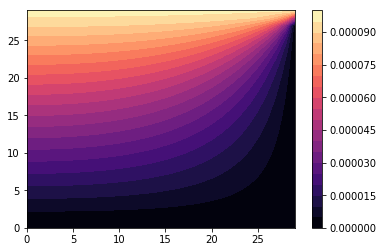

In [145]:
# simple plot of the velocity field
# since flow is going downard, i decide to plot -vy to have positive values
plt.contourf(x1, y1, -vy, 20, cmap=cm);
plt.colorbar()  ;

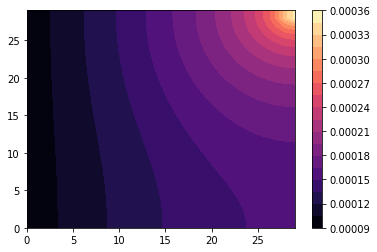

In [146]:
plt.contourf(x1, y1, vx, 20, cmap=cm);
plt.colorbar()  ;

## Stream function

The theory behind the stream function can be found on wikipedia.

The integral between two points defines the flux which goes through these two points. That means that the streamfunction everywhere on the bottom boundary (which has no flux has to be zero).

Then, the variation of the stream function $\psi$ are given as:

\begin{equation}
d\psi = - v_y dx + v_x dy
\end{equation}

Or, equivalently

\begin{equation}
\begin{array}{lll}
\displaystyle{\frac{\partial \psi}{\partial x}} & = & - v_y \\
\displaystyle{\frac{\partial \psi}{\partial y}} & = & v_x
\end{array}
\end{equation}

So we are going to compute the stream function simply by adding the computed velocity, starting from the bottom boundary (where it equals zero).



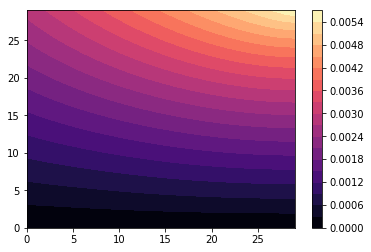

In [154]:
# the following code is not general. You probably need to adapt it.

psi = np.zeros((n_y,n_x))
psi[0,:] = 0 #Because zero flow on the bottom boundary
for i in range(1,n_y):
    for j in range (n_x):
        if (j == 0):
            psi[i,j] = (psi[i-1,j] + vx[i-1,j])
        else:
            psi[i,j] = (psi[i-1,j] + vx[i-1,j] + psi[i,j-1] - vy[i,j-1])/2


# and now we plot it    

plt.contourf(x1, y1, psi, 20, cmap=cm)
plt.colorbar();

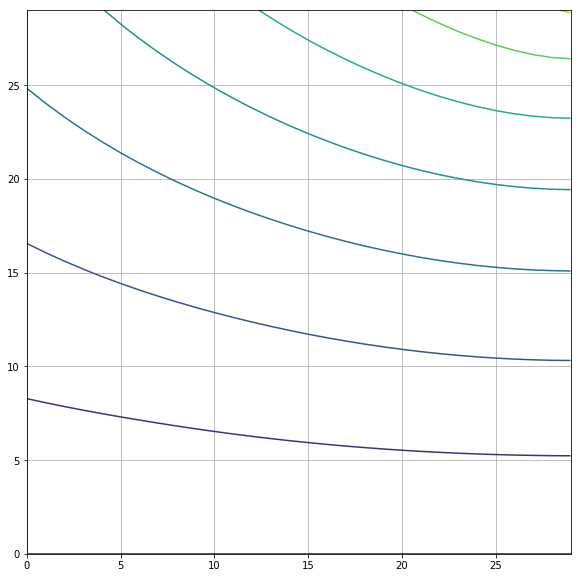

In [155]:
fig, ax = plt.subplots(1,1,figsize=(15,10))
cs=ax.contour(x1, y1, psi, lcolors='k')
ax.set_aspect(1)
ax.grid(True)